In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import imageio

In [2]:
#initialization

In [12]:
X =  np.array([[-4.5,0],[-9,0],[-1,0],[0,1],[2,1],[4,0],[5,1]])
S = np.array([[1],[0.2],[3]])
M =  np.array([[-4,0],[0,0],[8,0]])
P = np.array([[1/3],[1/3],[1/3]])


In [4]:
X =  np.array([[-3],[-2.5],[-1],[0],[2],[4],[5]])
S = np.array([[1],[0.2],[3]])
M =  np.array([[-4],[0],[8]])
P = np.array([[1/3],[1/3],[1/3]])

In [14]:
X =  np.array([[-3],[-2.5],[-1],[0],[2],[4],[5]])
S = np.array([[1],[0.2],[3]])
M =  np.array([[-4],[0],[8]])
P = np.array([[1/3],[1/3],[1/3]])

In [5]:
def GaussianMixture(X, M, S, P , Id ):
    if Id==0:
        S = np.sqrt(S)
        G = []
        for Xn in X:
            G.append([stats.norm(Mk,Sk).pdf(Xn) for Mk,Sk in zip(M,S)] )
        G = np.array(G)[:,:,0]
        return P.T * G
    if Id==1:
        S = np.sqrt(S)
        G = []
        for Xn in X:
            g = []
            for k in range(M.shape[0]):
                g.append( stats.norm(M[k],S[k]).pdf(Xn)  )
            G.append(g)
        G = np.array(G)[:,:,0]
        return P.T * G
    if Id==2:
        G = np.zeros((X.shape[0], M.shape[0]))
        for k in range(M.shape[0]):
            first_part = 1 / np.sqrt(2 * np.pi * S[k])
            second_part = np.exp(-(1 / (2 * S[k])) * (X - M[k, :]) ** 2)
            G[:, k] = np.prod(first_part * second_part, axis=1)
        return P.T * G
    if Id==3:
        S = np.array([ np.eye(X.shape[1])*Sk for Sk in S])
        G = np.zeros((X.shape[0], M.shape[0]))
        for k in range(M.shape[0]):
            G[:, k] = stats.multivariate_normal(M[k], S[k]).pdf(X)
        return P.T * G        

def calc_G( gaussianMixture ):  # returns an (N x K) array
    G = gaussianMixture
    G = G / np.sum(G , axis=1).reshape(-1,1)
    return G

def calc_Nk(G):   # returns an (1 x K) array
    return np.sum(G , axis=0).reshape(-1,1)

def calc_Nk2(G):   # returns an (1 x K) array
    N = []
    for k in range(G.shape[1]):
        nk = 0
        for n in range(G.shape[0]):
            nk += G[n][k]
        N.append(nk)
    return np.array(N).reshape(-1,1)
    
def calc_M(X, G, Nk): # returns an (K x D) array
    return G.T.dot(X) / Nk

def calc_M2(X, G, Nk): # returns an (K x D) array
    M = []
    for k in range(G.shape[1]):
        row = 0
        for n in range(X.shape[0]):
            row += G[n][k] * X[n]
        M.append(row)
    
    return np.array(M)/Nk
            

def calc_S2(X, G, Nk, M):
    S = []
    for k in range(M.shape[0]):
        row = 0
        for n in range(X.shape[0]):
            for d in range(X.shape[1]):
                row += G[n][k]*np.square(X[n][d]- M[k][d])
        S.append(row)
    return np.array(S).reshape(-1,1) /(X.shape[1] * Nk )

def calc_S(X, G, Nk, M):
    S = np.ones((M.shape[0],1))
    for k in range(M.shape[0]):
        S[k] = np.sum(np.sum(G[:, k].reshape((-1, 1))*np.square(X- M[k]), axis=1))

    return np.array(S) /(X.shape[1] * Nk )


def calc_P(Nk, N):
    return Nk/N
    
def logLikelihood( mixtureMatrix ):
    return np.sum(np.log(np.sum(mixtureMatrix, axis=1)))

def getPredictedValues(Gamma, M):
    return M[ Gamma.argmax(axis=1) ]

def getError(X , Xpred):
    np.square( np.sum(X-Xpred)/X.shape[0] )

def savePredictedImage(Xpred, shape, K):
    Xpred = (Xpred*255).astype(np.uint8)
    Xpred = Xpred.reshape(shape)
    imageio.imwrite('im_K' + str(K) + '.jpg' ,Xpred )

In [33]:
mix = GaussianMixture(X, M, S, P,2)
g = calc_G(mix)
nk = calc_Nk(g)
m = calc_M(X, g, nk)
calc_S(X, g , nk , m)

array([[0.14399988],
       [0.4384922 ],
       [1.52659412]])

In [6]:
im = imageio.imread('im.jpg')
shape = im.shape
im = im.reshape((im.shape[0]*im.shape[1],3))
X = im/255

In [ ]:
%%time

K = 4
M = np.random.uniform(0,1,(K,X.shape[1]))
S = np.random.uniform(0, 1, (K,1))
P = np.ones((K,1)) * 1/K
gaussianMixture = GaussianMixture(X, M, S, P,1)
iters = 30
i = 0
liks = []


while True:
    if (i%10==0):
        print(i)
    Gamma = calc_G(gaussianMixture)
    Nk = calc_Nk(Gamma)
    M = calc_M(X, Gamma, Nk)
    S = calc_S(X, Gamma, Nk , M)
    P = calc_P(Nk,X.shape[0])
    gaussianMixture = GaussianMixture(X, M, S, P,1)
    L = logLikelihood(gaussianMixture )
    liks.append(L)
    
    if (i>iters):
        break
    
    
    i+=1

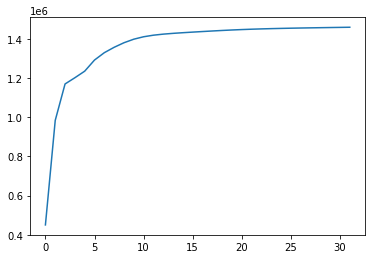

In [28]:
plt.plot( np.arange(len(liks)),liks )

In [26]:

Xpred = getPredictedValues(Gamma, M)
savePredictedImage(Xpred, shape, K)